<a href="https://colab.research.google.com/github/joshualewin6/Colab-Notebook/blob/main/JoshLewiU7proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Caifornia Cities

##Intro
I wanted to use bsplines to analyze population trends based on various factors, and after a whole lot of finding terrible datasets, I stumbled across a csv of every city in California with very little missing data. It has many useful predictors, and I knew I could build a reasonable model from it, so this dataset is what I settled on. Lets's import what we need.

In [1]:
!pip install git+https://github.com/pydata/xarray.git
!pip install bambi

  Cloning https://github.com/pydata/xarray.git to /tmp/pip-req-build-wgfrwk2l
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/xarray.git /tmp/pip-req-build-wgfrwk2l
  Resolved https://github.com/pydata/xarray.git to commit 0184702f16c3f744fc9096c7dac690626dcc6922
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for xarray: filename=xarray-2025.1.3.dev22+g0184702f-py3-none-any.whl size=1262235 sha256=fcc463b517e0766ed212c55b119704094efac82be6039000dcd86528b2d3554b
  Stored in directory: /tmp/pip-ephem-wheel-cache-jj8lt5vl/wheels/15/f9/46/ac58ec95d7761bd0b92f54d99c5d132719866f63745c3702ed
Successfully built xarray
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.1.2
    Uninstalling xarray-2025.1.2:
      Successfully uninstalled xarray-2025.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 3.1 MB/s eta 0:00:00
   ━

In [2]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import xarray as xr
import bambi as bmb
import pymc as pm

In [3]:
cities=pd.read_csv('https://raw.githubusercontent.com/joshualewin6/Colab-Notebook/refs/heads/main/california_cities.csv')
cities=cities.query('area_land_sq_mi < 100000 and area_water_sq_mi < 100000 and elevation_ft<1000000')
cities['log_pop']=np.log10(cities['population_total'])
cities['log_land']=np.log10(cities['area_land_sq_mi'])
cities['log_tot_area']=np.log10(cities['area_total_sq_mi'])
cities

,Unnamed: 0,city,latd,longd,elevation_m,elevation_ft,population_total,area_total_sq_mi,area_land_sq_mi,area_water_sq_mi,area_total_km2,area_land_km2,area_water_km2,area_water_percent,log_pop,log_land,log_tot_area
0,0,Adelanto,34.576111,-117.432778,875.0,2871.0,31765,56.027,56.009,0.018,145.107,145.062,0.046,0.03,4.501949,1.748258,1.748397
1,1,AgouraHills,34.153333,-118.761667,281.0,922.0,20330,7.822,7.793,0.029,20.260,20.184,0.076,0.37,4.308137,0.891705,0.893318
2,2,Alameda,37.756111,-122.274444,NaN,33.0,75467,22.960,10.611,12.349,59.465,27.482,31.983,53.79,4.877757,1.025756,1.360972
3,3,Albany,37.886944,-122.297778,NaN,43.0,18969,5.465,1.788,3.677,14.155,4.632,9.524,67.28,4.278044,0.252368,0.737590
4,4,Alhambra,34.081944,-118.135000,150.0,492.0,83089,7.632,7.631,0.001,19.766,19.763,0.003,0.01,4.919544,0.882581,0.882638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,477,Yountville,38.403056,-122.362222,30.0,98.0,2933,1.531,1.531,0.000,3.966,3.966,0.000,0.00,3.467312,0.184975,0.184975
478,478,Yreka,41.726667,-122.637500,787.0,2582.0,7765,10.053,9.980,0.073,26.036,25.847,0.188,0.72,3.890141,0.999131,1.002296
479,479,YubaCity,39.134722,-121.626111,18.0,59.0,64925,14.656,14.578,0.078,37.959,37.758,0.201,0.53,4.812412,1.163698,1.166015
480,480,Yucaipa,34.030278,-117.048611,798.0,2618.0,51367,27.893,27.888,0.005,72.244,72.231,0.013,0.02,4.710684,1.445417,1.445495


The data needed some tweaking, since bambi freaks out when I try to give it exponential priors. As such, I took the log of everything I was using that had range (0,inf), and will instead use mostly normal distributions. We're using the imperial system because 'murica, and it had less missing imperial values than metric.

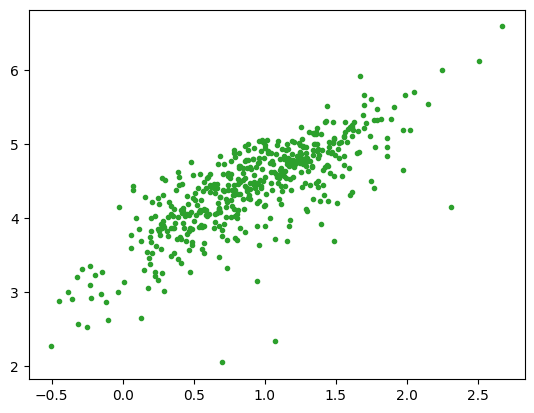

In [4]:
plt.plot(cities.log_land, cities.log_pop, "C2.", zorder=-3)

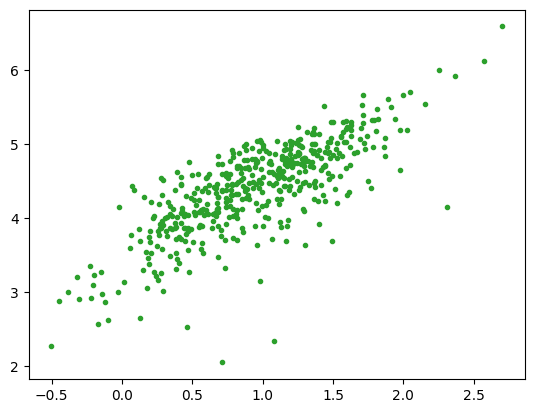

In [5]:
plt.plot(cities.log_tot_area, cities.log_pop, "C2.", zorder=-3)

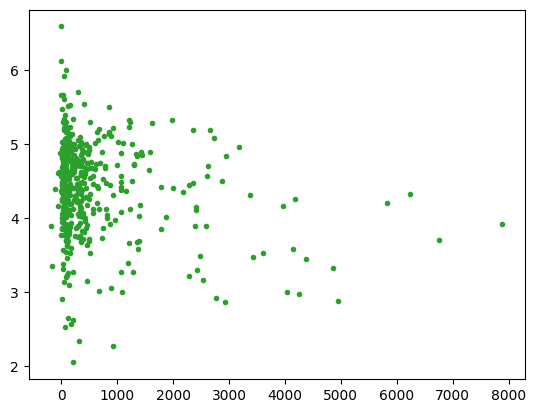

In [6]:
plt.plot(cities.elevation_ft, cities.log_pop, "C2.", zorder=-3)

These graphs are encoraging. We can draw some good relations from these.

##The Components of the Model
Let's make a causal DAG to determine what our models might include in terms of interactions or predictors.

In [23]:
import base64
from IPython.display import Image, display
import matplotlib.pyplot as plt

def mm(graph):
  graphbytes = graph.encode("ascii")
  base64_bytes = base64.b64encode(graphbytes)
  base64_string = base64_bytes.decode("ascii")
  display(
    Image(
      url="https://mermaid.ink/img/"
      + base64_string
    )
  )

mm("""
graph LR;
    Water-AKA-landTotInteraction--> Total;
    Land--> Pop;
    Land--> Water-AKA-landTotInteraction;
    Elev-..-> Water-AKA-landTotInteraction;
    Elev-..-> Pop;
    Total--> Pop;
""")

Since how little water area there is determines how strongly land area influences the total area, and elevation weakly influences whether there are lakes, ponds, etc., we can draw the three way interaction as such. As for the rest, land and area both strongly influence population, since that's more space to live (it remains to be seen which is stronger), while elevation has a weaker influnce, but more will live lower, since coastal cities are more populous. Let's run three models, each with just a predictor, to see how they compare, then include an interaction with the best one to see if it makes sense to incorporate it.

In [12]:
knots = [0.56,0.92,1.29]
model_land = bmb.Model("log_pop ~ bs(log_land, degree=3, knots=knots)", cities)
idata_land = model_land.fit(idata_kwargs={"log_likelihood":True})

Output()

<Axes: xlabel='log_pop'>

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


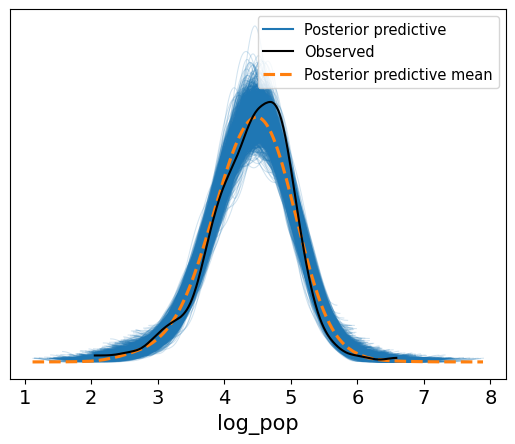

In [46]:
model_land.predict(idata_land, kind="response")
az.plot_ppc(idata_land)

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


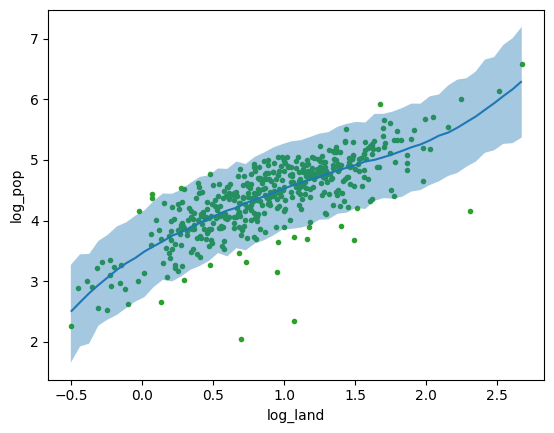

In [25]:
bmb.interpret.plot_predictions(model_land, idata_land, "log_land", pps= True)
plt.plot(cities.log_land, cities.log_pop, "C2.", zorder=-3)

In [26]:
knots = [0.56,0.96,1.31]
model_tot_area = bmb.Model("log_pop ~ bs(log_tot_area, degree=3, knots=knots)", cities)
idata_tot_area = model_tot_area.fit(idata_kwargs={"log_likelihood":True})

Output()

<Axes: xlabel='log_pop'>

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


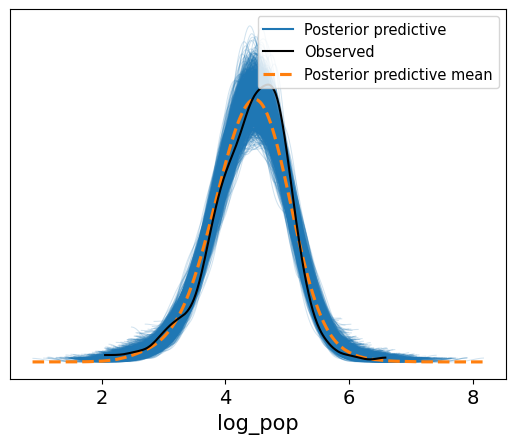

In [47]:
model_tot_area.predict(idata_tot_area, kind="response")
az.plot_ppc(idata_tot_area)

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


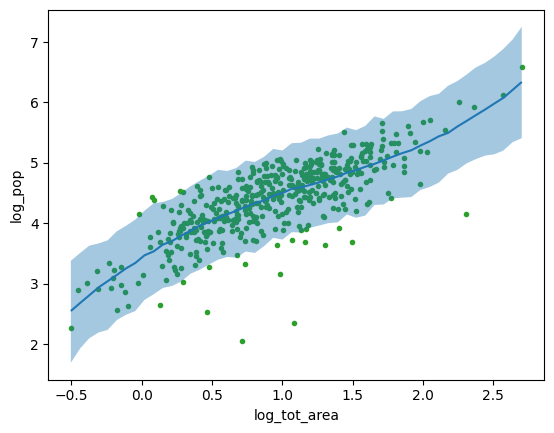

In [27]:
bmb.interpret.plot_predictions(model_tot_area, idata_tot_area, "log_tot_area", pps= True)
plt.plot(cities.log_tot_area, cities.log_pop, "C2.", zorder=-3)

In [28]:
knots = [300,700,1200]
model_elev = bmb.Model("log_pop ~ bs(elevation_ft, degree=3, knots=knots)", cities)
idata_elev = model_elev.fit(idata_kwargs={"log_likelihood":True})

Output()

<Axes: xlabel='log_pop'>

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


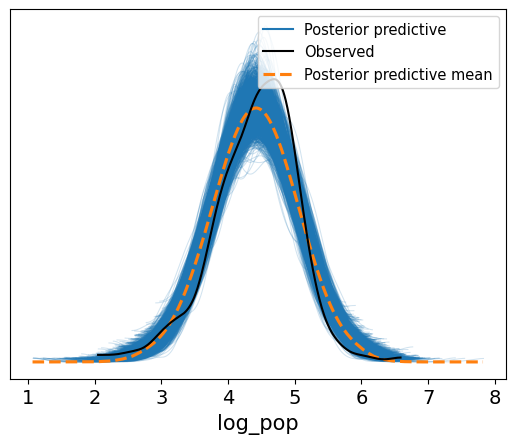

In [48]:
model_elev.predict(idata_elev, kind="response")
az.plot_ppc(idata_elev)

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


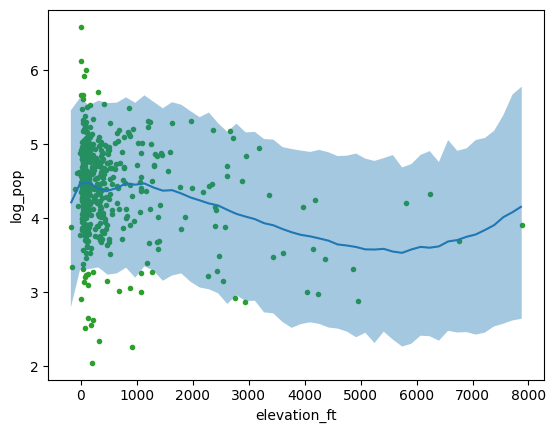

In [29]:
bmb.interpret.plot_predictions(model_elev, idata_elev, "elevation_ft", pps= True)
plt.plot(cities.elevation_ft, cities.log_pop, "C2.", zorder=-3)

In [33]:
knots_land = [0.56,0.92,1.29]
knots_ta = [0.56,0.96,1.31]
model_landw = bmb.Model("log_pop ~ bs(log_land, degree=3, knots=knots_land)+poly(log_tot_area, degree=3):poly(log_land, degree=3)", cities)
idata_landw = model_landw.fit(idata_kwargs={"log_likelihood":True})

Output()

This one failed on initial evaluation when I tried to interact bsplines, so I interacteed a simple polynomial to see if it made sense.

<Axes: xlabel='log_pop'>

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


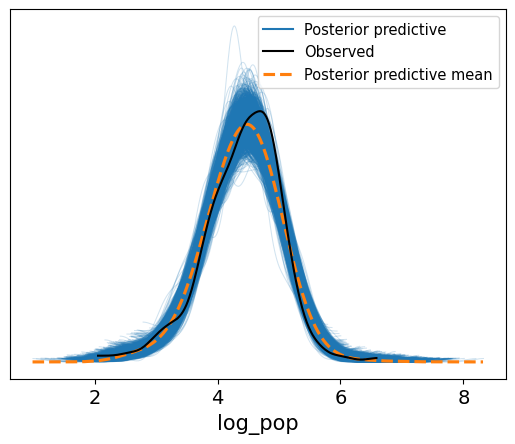

In [49]:
model_landw.predict(idata_landw, kind="response")
az.plot_ppc(idata_landw)

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


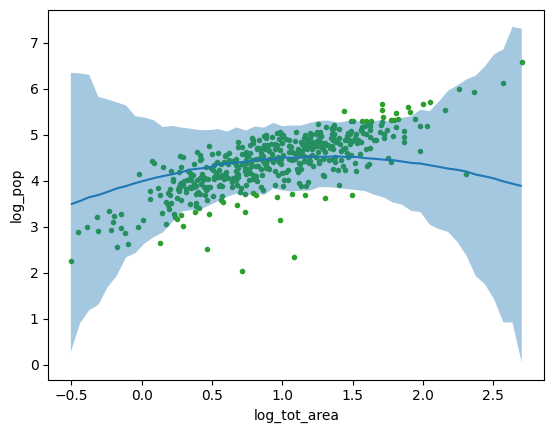

In [34]:
bmb.interpret.plot_predictions(model_landw, idata_landw, "log_tot_area", pps= True)
plt.plot(cities.log_tot_area, cities.log_pop, "C2.", zorder=-3)

Fat nope. It tries to make the relation a quadratic that drastically deviates from all the data, and nowhere is degree 2 even mentioned. we'll pass on the interaction for the rest of this.

##The Actual Models
These will all incorporate land area, the strongest influencer of population (unsurprisingly), and add something  (or nothing) to it.

In [35]:
cmp_df = az.compare( {"elev":idata_elev,"land":idata_land,"ta":idata_tot_area} )
cmp_df

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
land,0,-218.746953,11.143842,0.000000,0.878620,29.979454,0.000000,True,log
ta,1,-230.460593,11.059522,11.713640,0.083301,29.069148,8.591903,True,log
elev,2,-442.610575,8.501530,223.863622,0.038079,19.474464,26.843207,True,log


In [36]:
knots_land = [0.56,0.92,1.29]
knots_ta = [0.56,0.96,1.31]
model_land_tot = bmb.Model("log_pop ~ bs(log_land, degree=3, knots=knots_land)+bs(log_tot_area, degree=3, knots=knots_ta)", cities)
idata_land_tot = model_land_tot.fit(idata_kwargs={"log_likelihood":True})

Output()

<Axes: xlabel='log_pop'>

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


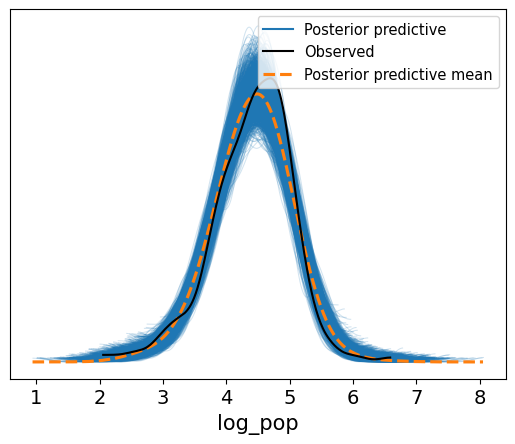

In [50]:
model_land_tot.predict(idata_land_tot, kind="response")
az.plot_ppc(idata_land_tot)

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


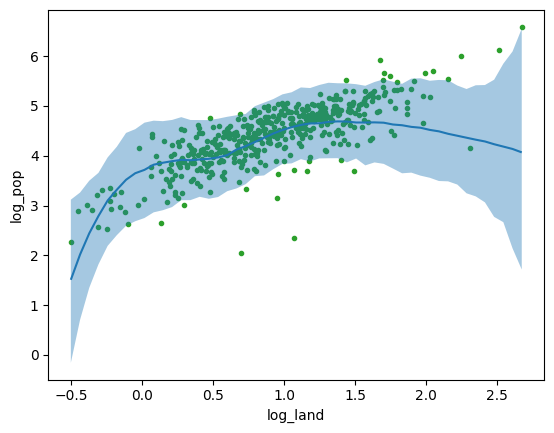

In [37]:
bmb.interpret.plot_predictions(model_land_tot, idata_land_tot, "log_land", pps= True)
plt.plot(cities.log_land, cities.log_pop, "C2.", zorder=-3)

In [14]:
knots_land = [0.56,0.92,1.29]
knots_elev = [300,700,1200]
model_land_elev = bmb.Model("log_pop ~ bs(log_land, degree=3, knots=knots_land)+bs(elevation_ft, degree=3, knots=knots_elev)", cities)
idata_land_elev = model_land_elev.fit(idata_kwargs={"log_likelihood":True})

Output()

<Axes: xlabel='log_pop'>

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


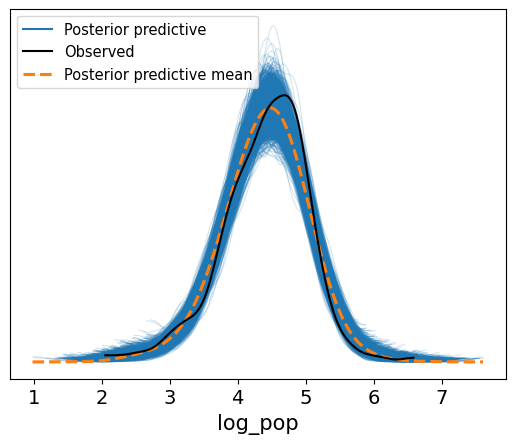

In [51]:
model_land_elev.predict(idata_land_elev, kind="response")
az.plot_ppc(idata_land_elev)

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


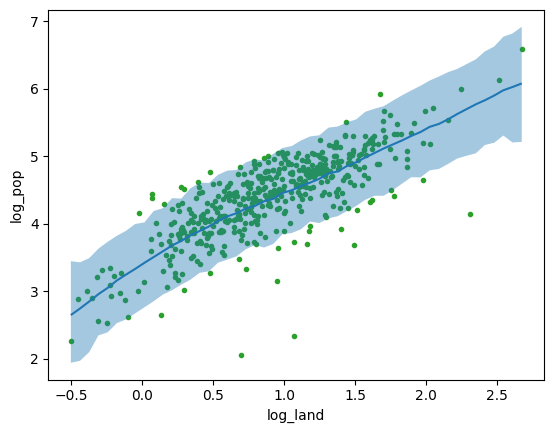

In [39]:
bmb.interpret.plot_predictions(model_land_elev, idata_land_elev, "log_land", pps= True)
plt.plot(cities.log_land, cities.log_pop, "C2.", zorder=-3)

In [40]:
cmp_df_a = az.compare( {"with_elev":idata_land_elev,"land":idata_land,"with_tot":idata_land_tot} )
cmp_df_a

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
with_elev,0,-179.288259,17.585006,0.000000,0.925329,34.859997,0.00000,True,log
land,1,-218.746953,11.143842,39.458695,0.074671,29.979454,10.01342,True,log
with_tot,2,-218.994992,16.757581,39.706733,0.000000,30.149794,9.87728,True,log


Surprisingly, elevation has a strong enough correlation to far and away be a good thing to encorporate in the final model. Thus, the simple addition of a land area bspline and elevation bspline is looking like the best so far.

##The Priors and Likelihood
This isn't usually saved for the end, but the priors haven't been bad enough to cripple the model, so I haven't addressed them. However, it is very obviously skew normal, which is why almost all the outliers are below the curve. So, I found some code to write a new bambi family for a skew normal distribution with a little leftward skew.

In [27]:
likelihood = bmb.Likelihood("SkewNormal", params=["mu", "sigma", "alpha"], parent="mu")
link = bmb.Link("identity")
family_skewnorm = bmb.Family("skewnormal", likelihood, link)
priors = {
    "sigma": bmb.Prior("HalfStudentT", nu=4, sigma=1),
    "alpha": bmb.Prior("Normal", mu=-2, sigma=10),
}

In [28]:
knots_land = [0.56,0.92,1.29]
knots_elev = [300,700,1200]
model_land_elev_skew = bmb.Model("log_pop ~ bs(log_land, degree=3, knots=knots_land)+bs(elevation_ft, degree=3, knots=knots_elev)", cities,family=family_skewnorm,priors=priors)
idata_land_elev_skew = model_land_elev_skew.fit(idata_kwargs={"log_likelihood":True})

Output()

<Axes: xlabel='log_pop'>

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


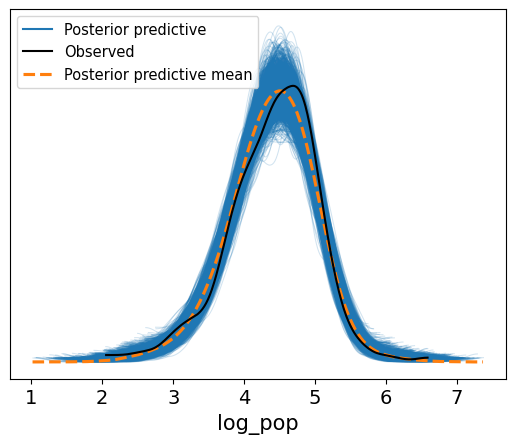

In [29]:
model_land_elev_skew.predict(idata_land_elev_skew, kind="response")
az.plot_ppc(idata_land_elev_skew)

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


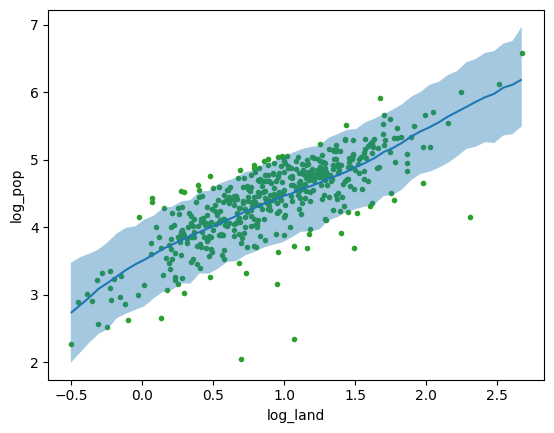

In [30]:
bmb.interpret.plot_predictions(model_land_elev_skew, idata_land_elev_skew, "log_land", pps= True)
plt.plot(cities.log_land, cities.log_pop, "C2.", zorder=-3)

In [31]:
cmp_df_ls = az.compare( {"with_skew":idata_land_elev_skew,"original":idata_land_elev} )
cmp_df_ls

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
with_skew,0,-146.285232,17.028436,0.000000,1.0,24.34140,0.000000,True,log
original,1,-179.794886,18.098203,33.509654,0.0,34.75276,13.157679,True,log


It works so much better that the weights literally just round to one and zero, so while it still isn't perfect, I think it's the best I'll get for now. Plus, looking at the graphs, it predicts the data pretty beautifully in all respects.

##Conclusion
Our ideal model to predict the log of the population of a California city is the cubic bspline of the log of the area plus the cubic bspline of the elevation. Also, our initial DAG is probably wrong. The more likely one probably looks a bit more like this.

In [16]:
import base64
from IPython.display import Image, display
import matplotlib.pyplot as plt

def mm(graph):
  graphbytes = graph.encode("ascii")
  base64_bytes = base64.b64encode(graphbytes)
  base64_string = base64_bytes.decode("ascii")
  display(
    Image(
      url="https://mermaid.ink/img/"
      + base64_string
    )
  )
mm("""
graph LR;
    Land--> Pop;
    Land--> Total;
    Water-..-> Total;
    Water-..-> Pop
    Elev--> Pop;
""")

That would explain why total area didn't work so well.

In conclusion, we can predict population quite well, and land area and elevation are the way to do it.